In [3]:
import numpy as np
import matplotlib.pyplot as plt
#import weno4 as weno
import scipy.optimize as sciopt
from tqdm import tqdm
outdir = r"C:\Users\nickd\PyFluid\gifs\ "

100%|██████████| 50/50 [00:00<00:00, 1935.68it/s]


1.3711309200802086
1.8983111454013208
2.075396901123425
2.183724295416028
2.2417748338373413
2.324752205914071
2.4034292298412088
2.422843702181286
2.462689032325841
2.4921787194265526
2.4778480454816108
2.5273757296680293
2.5109274402705744
2.5008051120371713
2.530457000468801
2.494782919517159
2.525345533588885
2.5126665846176888
2.4865546972174877
2.5197197932771314
2.4953937250585847
2.5092150855201103
2.5067672749603362
2.482998309605999
2.498426302855063
2.4867954396491374
2.481185076664374
2.4887991144985318
2.473543623155952
2.468581432803953
2.4681432999078963
2.458452620650941
2.46394119408657
2.4552346691138913
2.4459281939898694
2.4455755935990577
2.44101208212043
2.4375128134614825
2.4478300587715385
2.4412976401871633
2.4618057289331388
2.4593716955464666
2.4720369864236
2.471951269223995
2.477618738464396
2.4797595427117134
2.4804705750141887
2.4845236457455013
2.481285490349882
2.4863930294011602


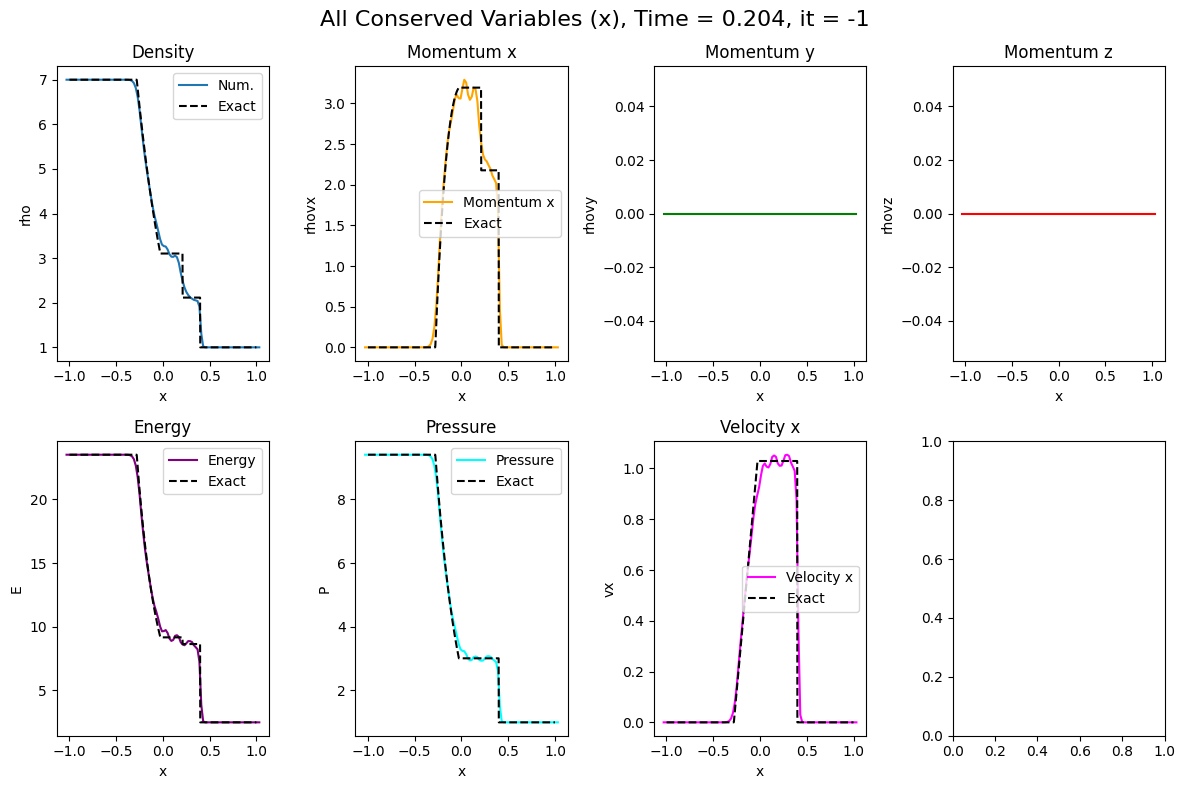

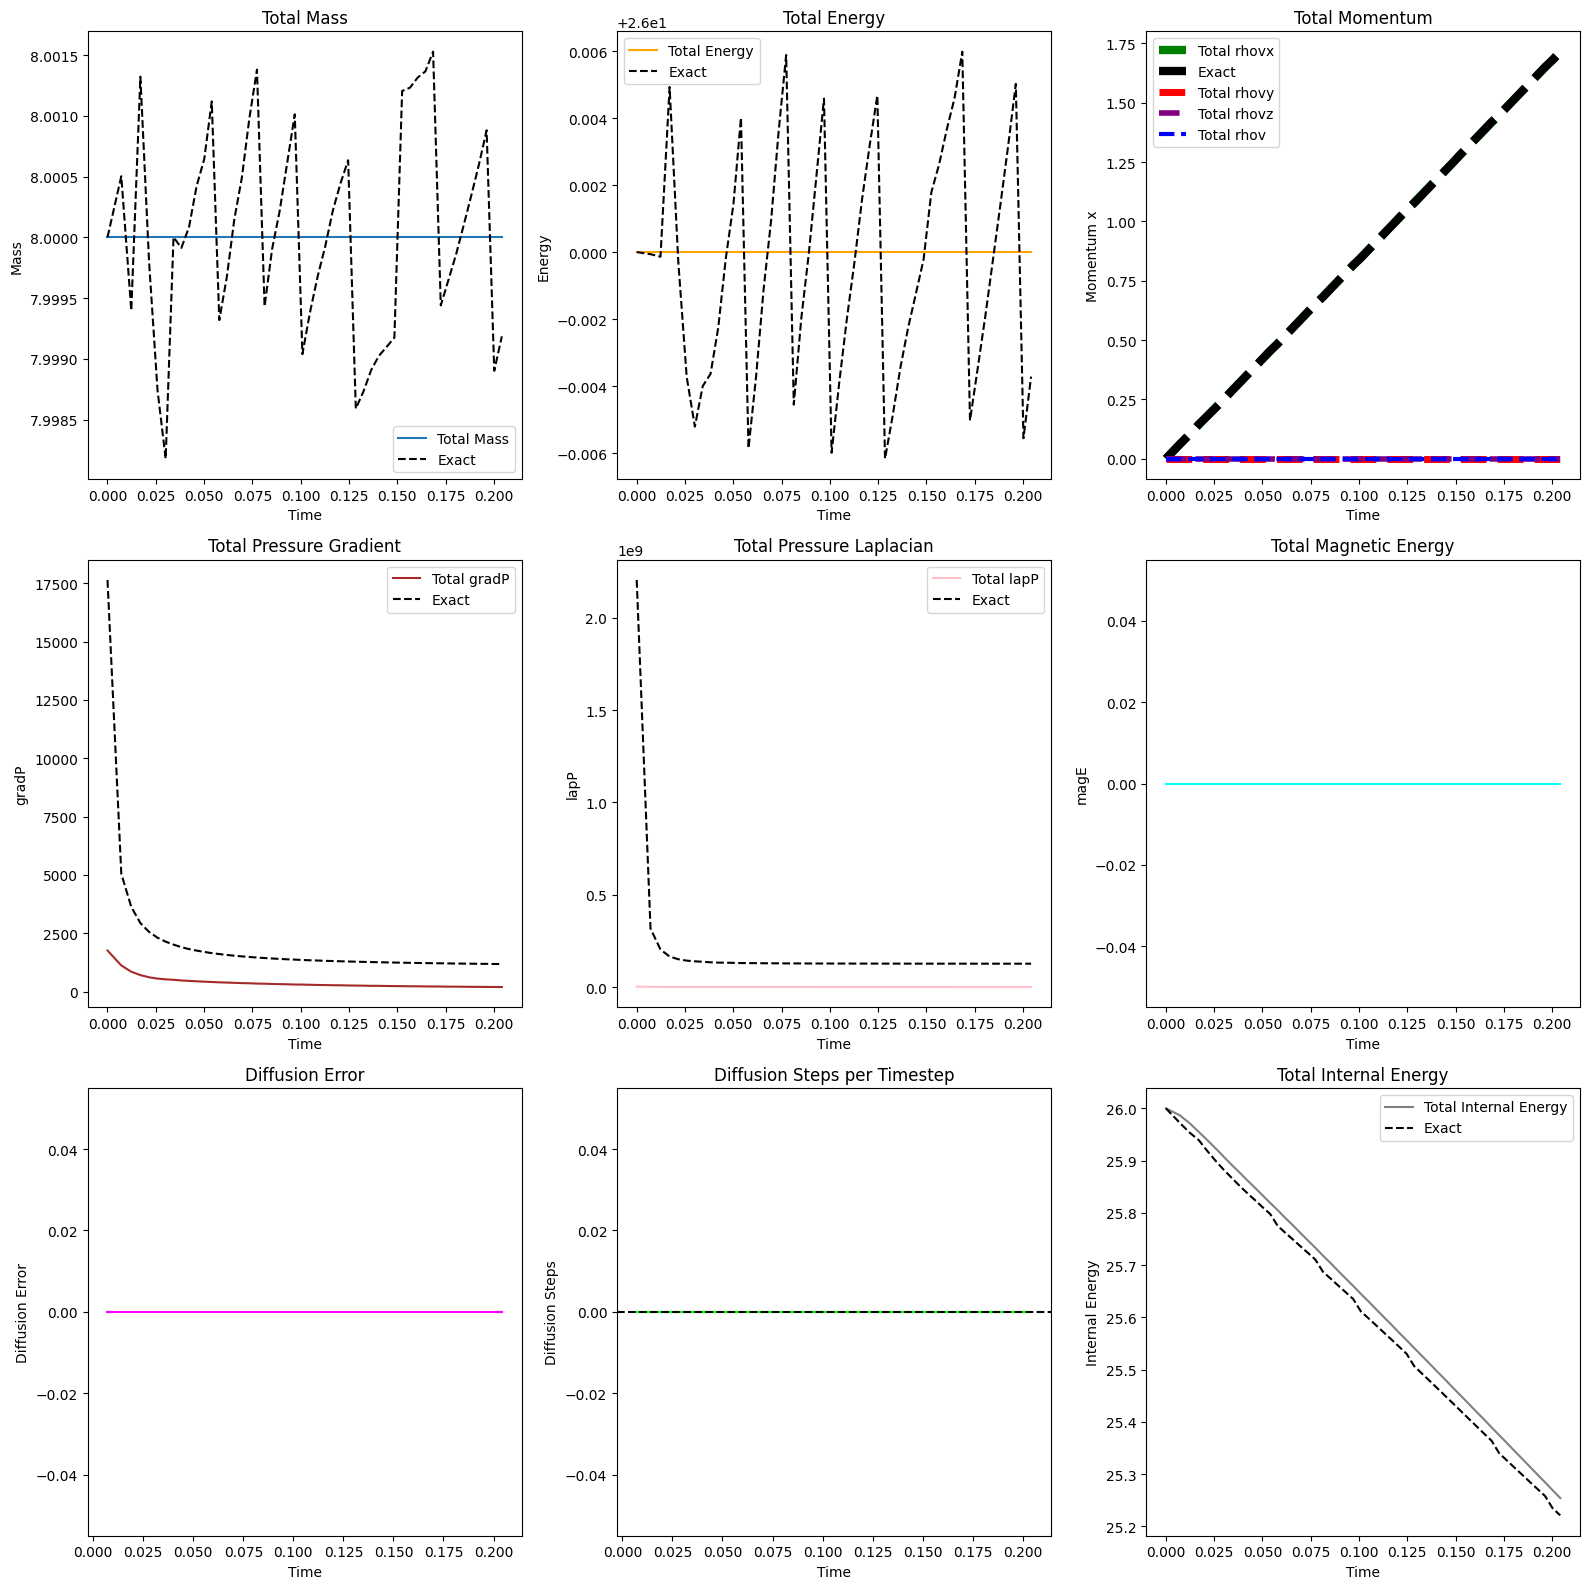

In [5]:
#1 Dimension MHD, Compressible, Adiabatic, Viscous, Resistive, Finite Volume.
def calc_sloplim_diff(a,b,out):
   out[...] = ((a + b)/2)

def calc_sloplim_minmod(a,b,out):
   out[...] = np.where(np.sign(a) == np.sign(b), np.where(np.abs(a) < np.abs(b), a, b), 0.0)

def calc_sloplim_superbee(a,b,out):
   out[...] = np.maximum(0,np.minimum(2*np.abs(a),np.abs(b)),np.minimum(np.abs(a),2*np.abs(b))) \
                  *np.sign(a)*np.where(np.sign(a) == np.sign(b),1.0,0.0)
def calc_sloplim_vanleer(a,b,out):
   out[...] = (2*a*b)/(a+b + 1e-16)*np.where(np.sign(a) == np.sign(b),1.0,0.0)
   out[np.where(out >=1e15)] = 0.0 #handle inf/nan cases

def calc_sloplim_mc(a,b,out):
   out[...] = np.minimum(0.5*(a+b),2*np.abs(a),2*np.abs(b))*np.sign(a)*np.where(np.sign(a) == np.sign(b),1.0,0.0)

def calc_v4(p3f,selff):
   return (p3f - selff.presR)*np.sqrt((1 - selff.gammaex)/(selff.rhoR*(p3f + selff.gammaex*selff.presR)))

def calc_v3(p3f,selff):
   return ((selff.presL**selff.betaex) - (p3f**selff.betaex))*np.sqrt(((1 - selff.gammaex**2)*(selff.presL**(1/selff.gamma))/((selff.gammaex**2)*selff.rhoL)))

def calc_root_pres3(p3f,selff):
   return(calc_v3(p3f,selff) - calc_v4(p3f,selff))

class fluid1DMHD:
   def __init__(self,x0,x1,nx,cfl,ici,bci,nsteps,fluxi,reconi,limi):
      #Initialize the base grid, ghost cells and interior.
      self.nsteps = int(nsteps)
      self.step= 0 #current iteration
      self.x0,self.x1 = x0,x1
      self.nx = int(nx)
      self.ici = ici; self.bci = bci; self.reconi = reconi; self.fluxi = fluxi
      self.ng = 2 #number of ghost cells
      self.limi = limi
      self.cflr = cfl #CFL ratio, run at 90% of max stable timestep
      self.build_grid()
      
      
      self.gmask = np.zeros(self.nxtot,dtype=bool);
      self.gmask[:self.ng] = True; self.gmask[-self.ng:] = True
      self.imask = ~self.gmask
      self.imasksl = slice(self.ng,-self.ng) #interior mask slice
      self.lhgslF = slice(0,self.ng) #left side ghost cell slice (L2R) 
      self.lhgslR = slice(self.ng-1, -1,-1) #left side ghost cell slice (R2L)  
      self.lhislF = slice(self.ng,2*self.ng) #left side interior slice (L2R)\
      self.lhislR = slice(2*self.ng-1, self.ng-1,-1) #left side interior slice (R2L)
      self.rhgslF = slice(-self.ng,None) #right side ghost cell slice (L2R)
      self.rhgslR = slice(-1, -(self.ng + 1),-1) #right side ghost cell slice (R2L)
      self.rhislF = slice(-2*self.ng,-self.ng) #right side interior slice (L2R)
      self.rhislR = slice(-(self.ng+1), -2*self.ng-1,-1) #right side interior slice (R2L)
      self.lhsmask = np.zeros(self.nxtot,dtype=bool); self.lhsmask[np.where(self.xg <= 0)] = True #left half domain
      self.lhsmask[0:self.ng] = False;
      self.rhsmask = np.zeros(self.nxtot,dtype=bool); self.rhsmask[np.where(self.xg > 0 )] = True #right half domain
      self.rhsmask[-self.ng:] = False;
      self.t = 0.0; self.dt = 0.0;
      
      self.ts = np.zeros(self.nsteps+1) #time storage
      self.dts = np.zeros(self.nsteps) #dt storage
      #1D MHD we have 7 variables (rho, rhovx, rhovy, rhovz, E, By, Bz) as our conserved variables
      # rho, 3 velocities, energy 2 magnetic fields
      self.nvar = 7;
      self.Uvec = np.zeros((self.nvar,self.nxtot)) #conserved variable state vector
      self.UvecintL= np.zeros((self.nvar,self.nxifs)) #interface conserved variable state vector
      self.UvecintR= np.zeros((self.nvar,self.nxifs)) #interface conserved variable state vector
      self.Uvecint= np.zeros((self.nvar,self.nxifs)) #interface conserved variable state vector
      self.Uvecs = np.zeros((self.nsteps+1,self.nvar,self.nxtot)) #conserved variable state vector storage
      self.Uvectest = np.zeros((self.nvar,self.nxtot)) #test conserved variable state vector

      self.Fvec = np.zeros((self.nvar,self.nxtot)) #flux vector
      self.Fvecint = np.zeros((self.nvar,self.nxifs)) #interface flux vector
      self.FvecintL = np.zeros((self.nvar,self.nxifs)) #interface left flux vector
      self.FvecintR = np.zeros((self.nvar,self.nxifs)) #interface right flux vector
      self.alphaint = np.zeros(self.nxifs) #max wave speed at interfaces
      self.alpha = np.zeros(self.nxtot)


      self.pvar = 7; #number of primitive variables (rho, vx, vy, vz, P, By, Bz)
      self.Pvec = np.zeros((self.pvar,self.nxtot)) #primitive variable state vector
      self.PvecintL = np.zeros((self.pvar,self.nxifs)) #interface primitive variable state vector
      self.PvecintR = np.zeros((self.pvar,self.nxifs)) #interface primitive variable state vector
      self.Pvectest = np.zeros((self.pvar,self.nxtot)) #test primitive variable state vector
      self.Pvecs = np.zeros((self.nsteps+1,self.pvar,self.nxtot)) #primitive variable state vector storage

      self.dPvecL = np.zeros((self.pvar,self.nx+2)) #left slope of primitive variables
      self.dPvecR = np.zeros((self.pvar,self.nx+2)) #right slope of primitive variables
      self.dPveclim = np.zeros((self.pvar,self.nx+2)) #slope limited slope of primitive variables

      self.speeds = 4; #number of auxiliary variables, (cs2,cs2Ax,cs2A,cs2f)
      self.cs2vec = np.zeros((self.speeds,self.nxtot)) #auxiliary variable state vector
      self.cs2vecintL = np.zeros((self.speeds,self.nxifs)) #interface auxiliary variable state vector
      self.cs2vecintR = np.zeros((self.speeds,self.nxifs)) #interface auxiliary variable state vector
      self.cs2vecint = np.zeros((self.speeds,self.nxifs))

      
      self.diagvar = 11; #Diagnostic scalars total(mass, energy, internal energy, rhovx, rhovy, rhovz, rhov, gradP, lapP, magE, KE)
      self.diagnostics = np.zeros((self.nsteps+1,self.diagvar)) #diagnostic scalars storage

      self.Uvecexacts = np.zeros((self.nsteps+1,self.nvar,self.nxhr))
      self.Pvecexacts = np.zeros((self.nsteps+1,self.pvar,self.nxhr))
      self.diagnostics_exact = np.zeros((self.nsteps+1,self.diagvar)) #diagnostic scalars storage for exact solution
      

      if self.ng == 2:
         #ng - 2 = 0
         self.outeri = None;
      else:
         self.outeri = -(self.ng -2);
      if self.limi == 0:
         self.calc_slopelimit = calc_sloplim_diff
      elif self.limi == 1:
         self.calc_slopelimit = calc_sloplim_minmod
      elif self.limi == 2:
         self.calc_slopelimit = calc_sloplim_superbee
      elif self.limi == 3:
         self.calc_slopelimit = calc_sloplim_vanleer
      elif self.limi == 4:
         self.calc_slopelimit = calc_sloplim_mc
      elif self.limi not in [0,1,2,3,4]:
         raise ValueError("Slope limiter not recognized.")
      if self.reconi == 0:
         self.LRreconP = self.LRreconP_pwconstant
      if self.reconi == 1:
         self.LRreconP = self.LRreconP_pwlinear_slopelimited
      elif self.reconi not in [0,1]:
         raise ValueError("Reconstruction method not recognized.")
      if self.fluxi == 0:
         self.calc_riemann_fluxes = self.calc_LLF_fluxes

      #Physics Assumptions
      self.gamma = 1.4 #adiabatic index
      self.kappa = 1.0 #entropy
      self.rhob = 1.0 #background density
      self.pres0 = self.kappa*self.rhob**self.gamma #background pressure
      self.cs20 = self.gamma*self.kappa*self.rhob**(self.gamma-1) #background sound speed squared
      self.cs0 = np.sqrt(self.cs20) #background sound speed
      self.Bx = 0.0 #background magnetic field in x direction
      self.By0= 0.0
      self.Bz0 = 0.0
      #Diffusion stuff
      self.Uvect = np.copy(self.Uvec) #temporary conserved variable state vector
     
      self.difftol = 1e-14
      self.nu = 0.1*self.dx*np.sqrt(self.cs20) #kinematic viscosity coefficient
      self.mu = self.nu*self.rhob #dynamic viscosity coefficient
      self.lam = -(2/3)*self.mu #second viscosity coefficient
      self.eta = 1e-4
      self.differr = 0.0
      self.differrs = np.zeros(self.nsteps)
      self.diffstep = 0
      self.diffsteps = np.zeros(self.nsteps)
      self.diffstepmax = 1e4
      self.stress = np.zeros((3,self.nxtot)) #stress tensor t_xx, t_xy, t_xz
      self.dx_stress = np.zeros((3,self.nxtot)) #x derivative of stress tensor
      self.rhoPv0 = np.zeros(6) #rho_L0, P_L0, vx_L0, rho_R0, P_R0, vx_R0
      self.rhoL,self.presL,self.vxL,self.rhoR,self.presR,self.vxR = 0.0,0.0,0.0,0.0,0.0,0.0


      #initialize conserved variables
      self.apply_ics()
      self.sync_state() #BC's and aux variables
      #Save initial state
      self.Uvecs[0,:,:] = self.Uvec
      self.Pvecs[0,:,:] = self.Pvec
      self.ts[0] = self.t 
      
      self.run_and_store()

      #After Run is done
      self.compute_diagnostics(self.dx,self.Uvecs[:,:,self.imasksl],self.Pvecs[:,:,self.imasksl],self.diagnostics)
      if self.Bx == 0.0 and np.max(np.abs(self.Uvec[5:7,:])) == 0.0:
         self.boolmag = False
      else:
         self.boolmag = True
      
      #Rebuild exact solution for all variables :)
      if self.ici==0:
         self.calc_exact_sod()
         self.compute_diagnostics(self.dxhr,self.Uvecexacts,self.Pvecexacts,self.diagnostics_exact)
      
   def build_grid(self):
      self.nxtot = self.nx + 2*self.ng #total number of grid points
      self.L = self.x1-self.x0
      self.dx = self.L/ (self.nx )
      self.xg = np.linspace(x0-(self.ng-0.5)*self.dx,x1+(self.ng-0.5)*self.dx,self.nxtot, endpoint=True) #symmetric grid with ghost cells
      self.Lcc = self.xg[-self.ng-1] - self.xg[self.ng] #cell centered domain length for smooth solutions
      self.gtol = 1e-14
      assert(np.isclose(self.xg[1]-self.xg[0], self.dx, rtol = self.gtol))
      
      self.xi = self.xg[self.ng:-self.ng] #interior grid
      self.nxifs = self.nx + 1 #number of interfaces
      self.xgi = np.linspace(self.xg[self.ng]-0.5*self.dx,self.xg[-self.ng-1]+0.5*self.dx,self.nxifs,endpoint=True) #grid interfaces

      assert(np.isclose(self.xgi[1]-self.xgi[0], self.dx, rtol = self.gtol))
       #Interior domain length
      assert(np.isclose((self.nx)*self.dx,self.L, rtol = self.gtol))
      self.nxhr = 10*self.nx #number of points for high res grid
      self.dxhr = self.L/ (self.nxhr)
      self.xghr = np.linspace(self.x0 + 0.5*self.dxhr,self.x1 - 0.5*self.dxhr,self.nxhr, endpoint=True) #high res grid
      assert(np.isclose(self.xghr[1]-self.xghr[0], self.dxhr, rtol = self.gtol))
   
   def run_and_store(self):
      for i in tqdm(range(self.nsteps)):
         #Interface Reconstruction on prim and p2con
         self.LRp_p2c_recon_all()
         #Compute stable timestep
         self.calc_dt_alpha()
         #Update conserved variables with LLF
         self.calc_riemann_and_update()
         #con2prim
         self.con2prim(self.Uvec,self.Pvec)
         #BC on prim and p2con
         self.sync_state()
         #Diffusion step
         #self.diff_update()
         #BC's and aux variables
         #self.sync_state()
         

         self.t += self.dt
         self.step += 1
         self.save_state(self.step)

   def sync_state(self):
      self.apply_bcs()
      self.prim2con(self.Pvec,self.Uvec);
      

   def apply_ics(self):
      self.delrho = (6)*self.rhob;
      self.delP = self.delrho*self.cs20;
      self.Pvec[0,self.imask] += self.rhob #background density
      self.Pvec[4,self.imask] += self.pres0 #background pressure
      self.U0width = 0.25
      if self.ici in [0,1]:
         #Sod shock tube
         if self.ici == 0: #sod shock (L)
            imasksided = self.lhsmask
         elif self.ici == 1: #sod shock (R)
            imasksided = self.rhsmask
         self.icname = "Sod.Shock"
         self.Pvec[5,self.imask] -= 2*self.By0 #background By magnetic field
         self.Pvec[0,imasksided]   += self.delrho #density perturbation
         self.Pvec[4,imasksided]   += self.delP #pressure perturbation
         self.Pvec[5,imasksided]   += self.By0 #By magnetic field
         self.Pvec[6,imasksided]   += self.Bz0 #Bz magnetic field
         self.rhoPv0[...] = [self.Pvec[0,self.ng],self.Pvec[4,self.ng],self.Pvec[1,self.ng]/self.Pvec[0,self.ng], \
                            self.Pvec[0,-self.ng-1],self.Pvec[4,-self.ng-1],self.Pvec[1,-self.ng-1]/self.Pvec[0,-self.ng-1]]
         self.rhoL,self.presL,self.vxL,self.rhoR,self.presR,self.vxR = self.rhoPv0

      if self.ici == 2:
         #square pulse
         self.icname = "Square.Pulse"
         sqmask = np.where(np.abs(self.xi) < self.U0width)
         self.Pvec[0,sqmask] += self.delrho #density perturbation
         self.Pvec[4,sqmask] += self.delP #pressure perturbation
         self.Pvec[1,sqmask] += self.cs0*(self.delrho/self.rhob) #velocity perturbation
      if self.ici == 3:
         #gaussian pulse
         self.icname = "Gaussian.Pulse"
         gfac = 1/(self.U0width*np.sqrt(2*np.pi)) * np.exp(-0.5*np.square(self.xi/self.U0width))
         self.Pvec[0,self.imask]+=gfac*self.delrho #density perturbation
         self.Pvec[4,self.imask]+=gfac*self.delP #pressure perturbation
         self.Pvec[1,self.imask]+=gfac*(self.cs0*(self.delrho/self.rhob)) #velocity perturbation
      if self.ici == 4:
         #Linear wave
         self.icname = "Linear.Wave"
         Lmod = self.Lcc + self.dx; 
         self.kx = (2*np.pi/Lmod) #wave number
         self.Pvec[0,self.imask] += self.delrho*np.sin(self.kx*self.xi) #density perturbation
         self.Pvec[4,self.imask] += self.delP*np.sin(self.kx*self.xi) #pressure perturbation
         self.Pvec[1,self.imask] += 0*(np.sqrt(self.cs20)*(self.delrho/self.rhob))*np.sin(self.kx*self.xi) #velocity perturbation
      if self.ici == 5:
         self.icname = "Background" 
      if self.ici not in [0,1,2,3,4,5]:
         raise ValueError("Initial condition not recognized.")
      assert(np.all(self.Pvec[0,self.imask] > 0.0)) #check for positive density
      assert(np.all(self.Pvec[4,self.imask] > 0.0)) #check for positive pressure

      self.sync_state()
      
      self.test_c2pp2c_p2cc2p()

   def test_c2pp2c_p2cc2p(self):
      self.con2prim(self.Uvec,self.Pvectest)
      self.prim2con(self.Pvectest,self.Uvectest)
      assert(np.sum(np.abs(self.Uvectest - self.Uvec))*self.dx < 1e-14)
      self.prim2con(self.Pvec,self.Uvectest)
      self.con2prim(self.Uvectest,self.Pvectest)
      assert(np.sum(np.abs(self.Pvectest - self.Pvec))*self.dx < 1e-14)

   def con2prim(self,uvecf,pvecout):
      pvecout[0,:] = uvecf[0,:] #density
      pvecout[1:4,:] = uvecf[1:4,:]/uvecf[0,:] #velocities
      pvecout[5:7,:] = uvecf[5:7,:]/uvecf[0,:] #magnetic fields
      pvecout[4,:] = (self.gamma-1)*(uvecf[4,:] - 0.5*uvecf[0,:]*np.square(pvecout[1:4,:]).sum(axis=0) - 0.5*(np.square(uvecf[5:7,:]).sum(axis=0) + self.Bx**2)) #pressure
   
   def prim2con(self,pvecf,uvecout):
      uvecout[0,:] = pvecf[0,:] #density
      uvecout[1:4,:] = pvecf[0,:]*pvecf[1:4,:] #momentum
      uvecout[5:7,:] = pvecf[5:7,:] #magnetic fields
      self.calc_energy(pvecf,uvecout)

   def calc_energy(self,pvecf,uvecout):
      uvecout[4,:] = pvecf[4,:]/(self.gamma-1) + 0.5*pvecf[0,:]*np.square(pvecf[1:4,:]).sum(axis=0) + 0.5*(np.square(pvecf[5:7,:]).sum(axis=0) + self.Bx**2) #energy

   def calc_exact_sod(self):
      ttg, xtg = np.meshgrid(self.ts,self.xghr,indexing='ij')
      ttg[ttg ==0] = 1e-14 #Start the exact solution at t = 0+ 
      self.xi = xtg/ttg 
      self.csL = np.sqrt(self.gamma*self.presL/self.rhoL);self.csR = np.sqrt(self.gamma*self.presR/self.rhoR);
      self.gammaex = (self.gamma - 1.0)/(self.gamma + 1.0); self.betaex = (self.gamma - 1)/(2*self.gamma);
      self.pres3 = (self.presL + self.presR)/2 #initial guess
      self.pres3 = sciopt.brentq(calc_root_pres3,self.presR,self.presL,args=(self,),xtol=1e-12,full_output=False)

      self.rho3 = self.rhoL * (self.pres3/self.presL)**(1/self.gamma)

      self.vShock = self.vxR + self.csR*np.sqrt(((self.gamma - 1) + self.pres3*(self.gamma + 1))/(2*self.gamma))
      self.vContact = self.vxL + (2*self.csL/(self.gamma - 1))*(1 - ((self.pres3*self.presR)/self.presL)**((self.gamma - 1)/(2*self.gamma)))
      self.vFanright = self.vContact - np.sqrt(self.gamma*self.pres3/self.rho3)

      self.vx3 = self.vContact#self.vxR + (self.pres3 - self.presR) / np.sqrt((self.rhoR/2)*(self.gamma+1)*self.pres3 + (self.gamma-1)*self.presR)
      

      self.pres4 = self.pres3
      self.rho4 = self.rhoR*((self.pres4/self.presR + self.gammaex)/(1 + self.gammaex*self.pres4/self.presR))
      self.vx4 = self.vx3
      #Interface velocities are (-csL, vFanright, vContact, vShock)
      v1 = -self.csL; v2 = self.vFanright; v3 = self.vContact; v4 = self.vShock
      r1f = np.where(self.xi < v1,1.0,0.0)
      r2f = np.where((self.xi < v2) & (self.xi >= v1),1.0,0.0)
      r3f = np.where((self.xi < v3) & (self.xi >= v2),1.0,0.0)
      r4f = np.where((self.xi < v4) & (self.xi >= v3),1.0,0.0)
      r5f = np.where(self.xi >= v4,1.0,0.0)
      assert(np.sum(r1f + r2f + r3f + r4f + r5f)/(self.nxhr*(self.nsteps+1))==1.0) #check that all regions accounted for

      #Region 2 requires a bit of work
      u2x = (2/(self.gamma+1)) * (self.csL + self.xi)*r2f
      rho2x = self.rhoL*(1 - ((self.gamma - 1)/2)*(u2x/self.csL))**(2/(self.gamma-1))
      pres2x = self.presL* (rho2x/self.rhoL)**self.gamma
      
      self.Pvecexacts[:,0,:] = r1f*self.rhoL + r2f*rho2x + r3f*self.rho3 + r4f*self.rho4 + r5f*self.rhoR;
      self.Pvecexacts[:,1,:] = r1f*self.vxL + r2f*u2x + r3f*self.vx3 + r4f*self.vx4 + r5f*self.vxR;
      self.Pvecexacts[:,4,:] = r1f*self.presL + r2f*pres2x + r3f*self.pres3 + r4f*self.pres4 + r5f*self.presR;
      
      for i in range(self.nsteps+1):
         self.prim2con(self.Pvecexacts[i,:,:],self.Uvecexacts[i,:,:])

   def calc_speeds(self,pvecf,cs2out):
      #Calc wave speeds (cs2,cs2Ax,cs2A,cs2f)
      cs2out[0,:] = self.gamma*pvecf[4,:]/pvecf[0,:] #sound speed squared
      cs2out[1,:] = np.square(self.Bx)/pvecf[0,:] #Alfven speed squared in x direction
      cs2out[2,:] = (self.Bx**2 + np.square(pvecf[5:,:])).sum(axis=0)/pvecf[0,:] #total Alfven speed squared
      cs2out[3,:] = 0.5*(cs2out[0,:] + cs2out[2,:] \
                  + np.sqrt((cs2out[0,:] + cs2out[2,:])**2 - 4*cs2out[0,:]*cs2out[1,:])) #fast magnetosonic speed squared

   def LRp_p2c_recon_all(self):
      self.LRreconP(self.Pvec,self.PvecintL,self.PvecintR) #reconstruct conserved variables at all interfaces
      self.prim2con(self.PvecintL,self.UvecintL); self.prim2con(self.PvecintR,self.UvecintR); #get conserved variables at interfaces
      self.calc_speeds(self.PvecintL,self.cs2vecintL); self.calc_speeds(self.PvecintR,self.cs2vecintR); #calc speeds at interfaces
      self.calc_anfluxes(self.UvecintL,self.PvecintL,self.FvecintL) #calc fluxes at left interfaces
      self.calc_anfluxes(self.UvecintR,self.PvecintR,self.FvecintR) #calc fluxes at right interfaces
   
   def LRreconP_pwconstant(self, pvecf,pvecintLf,pvecintRf):
      #Piecewise constant reconstruction
      pvecintLf[...] = pvecf[:, self.ng-1:-(self.ng)]
      pvecintRf[...] = pvecf[:, self.ng:-(self.ng-1)]

   def LRreconP_pwlinear_slopelimited(self,pvecf,pvecintLf,pvecintRf):
      self.dPvecL[...] = pvecf[:,self.ng-1:-(self.ng-1)] - pvecf[:,self.ng-2:-(self.ng)]
      self.dPvecR[...] = pvecf[:,self.ng:self.outeri] - pvecf[:,self.ng-1:-(self.ng-1)]
      self.calc_slopelimit(self.dPvecL,self.dPvecR,self.dPveclim)
      pvecintLf[...] = pvecf[:,self.ng-1:-(self.ng)] + 0.5*self.dPveclim[:,0:-1]
      pvecintRf[...] = pvecf[:,self.ng:-(self.ng-1)] - 0.5*self.dPveclim[:,1:]

   def calc_riemann_and_update(self):
      self.calc_riemann_fluxes(self.alphaint,self.UvecintL, self.UvecintR,self.PvecintL,self.PvecintR, \
                               self.FvecintL, self.FvecintR, self.Fvecint)
      self.Uvec[:,self.imask] -= (self.dt/self.dx)*(self.Fvecint[:,1:] - self.Fvecint[:,:-1])

   def calc_stressdivstress(self,auxvecf,stressf,divstressf):
      stressf[:,:] = self.mu*np.gradient(auxvecf[0:3,:],self.dx,axis=1) #stress tensor
      stressf[0,:] += (self.lam + (1/3)*self.mu)*np.gradient(auxvecf[0,:],self.dx) #add normal stress to t_xx
      divstressf[:,:] = np.gradient(stressf[:,:],self.dx,axis=1) #divergence of stress tensor

   def calc_diff_iteration(self,uvec1,uvec2,dtf):
      uvec2[1:4]= dtf*self.dx_stress + uvec1[1:4]
      self.calc_aux(uvec2,self.Auxvect)
      self.calc_stressdivstress(self.Auxvect,self.stress,self.dx_stress)
      self.differr = np.sum(np.abs(uvec2[1:4] - dtf*self.dx_stress - uvec1[1:4])) / np.sum(np.abs(uvec2[1:4])) #Relative convergence error

   def diff_update(self):
      self.Uvect = np.copy(self.Uvec)
      self.calc_aux(self.Uvect,self.Auxvect)
      self.calc_stressdivstress(self.Auxvect,self.stress,self.dx_stress)
      self.calc_diff_iteration(self.Uvec,self.Uvect,self.dt)
      self.diffstep = 1
      while (self.differr > self.difftol) & (self.diffstep < self.diffstepmax):
          self.calc_diff_iteration(self.Uvec, self.Uvect, self.dt)
          self.diffstep += 1
      self.Uvec = self.Uvect.copy()
      self.Uvec[4,:] += -self.dt*np.sum(self.Auxvect[0:3,:]*self.dx_stress[:,:],axis=0) #update energy with viscous heating
      self.Uvec[4,:] += self.eta*self.dt*np.square(np.gradient(self.Uvec[5:7,:],self.dx,axis=1)).sum(axis=0) #update energy with resistive heating
      self.differrs[self.step] = self.differr
      self.diffsteps[self.step] = self.diffstep
      
   def calc_dt_alpha(self):
      self.alphaint = np.maximum(np.abs(self.PvecintL[1,:]) + np.sqrt(self.cs2vecintL[3,:]),np.abs(self.PvecintR[1,:]) + np.sqrt(self.cs2vecintR[3,:])) #max wave speed at interfaces
      #alternatively take over cell centered max wave speed
      #self.calc_speeds(self.Pvec,self.cs2vec)
      #self.alpha = np.maximum(np.abs(self.Pvec[1,:]) + np.sqrt(self.cs2vec[3,:]),np.abs(self.Pvec[1,:]) + np.sqrt(self.cs2vec[3,:])) #max wave speed at cell centers
      at = self.alphaint
      print(np.max(at))
      self.dt = self.cflr*self.dx/(np.max(at)) #dt from CFL condition
      #print(np.max(at))
      

   def wenorecon_all(self,uvecf,auxvecf,uvecintf,auxvecintf,fluxvecintf):
      for i in range(self.nvar):
         uvecintf[i,:] = weno.weno4(self.xgi,self.xg,uvecf[i,:])
      for i in range(self.auxvar):
         auxvecintf[i,:] = weno.weno4(self.xgi,self.xg,auxvecf[i,:])
      self.calc_anfluxes(uvecintf,auxvecintf,fluxvecintf);
   
   def calc_LLF_fluxes(self,alphaintf,uvecintL, uvecintR, pvecintL,pvecintR, fvecintL, fvecintR, fvecint):
      fvecint[...] = 0.5*(fvecintL + fvecintR) - 0.5*alphaintf*(uvecintR - uvecintL)

   def calc_anfluxes(self,uvecf, pvecf, fluxvecf):
      fluxvecf[0,:] = uvecf[1,:] #mass flux
      fluxvecf[1:4,:] = uvecf[1,None,:]*pvecf[1:4,:] \
            - self.Bx*np.vstack([self.Bx*np.ones(len(uvecf[0,:])),uvecf[5:7,:]]) #momentum fluxes
      fluxvecf[1,:] += pvecf[4,:] #add pressure to x momentum flux
      fluxvecf[4,:] = (uvecf[4,:] + pvecf[4,:])*pvecf[1,:] - (self.Bx**2)*pvecf[0,:] \
                     - self.Bx*np.sum(uvecf[5:,:]*pvecf[1:3,:],axis=0) #energy flux
      fluxvecf[5:7,:] = pvecf[5:,:]*pvecf[1,:] - self.Bx*pvecf[2:4,:] #By,Bz flux

   def compute_diagnostics(self,dxf,uvecsf,pvecsf,diagvecf):
      diagvus = np.array([0,1,3,4,5]) #mass, energy, rhovx, rhovy, rhovz
      diagvauxs = np.array([2,7,8,9,10]) #internal energy, gradP, lapP, magE, KE
      uvecus = np.array([0,4,1,2,3])#density, energy, rhovx, rhovy, rhovz
   
      for j in range(len(diagvus)):
         diagvecf[:,diagvus[j]] = np.sum(uvecsf[:,uvecus[j],:],axis=1)*dxf
         #diagvecf[:,diagvus[j]] -= (uvecf[:,uvecus[j],0] + uvecf[:,uvecus[j],-1])*dxf/2 #Subtract off last 2 volume, they extend outside
      diagvecf[:,2] = np.sum((pvecsf[:,4,:]/(self.gamma - 1))*dxf,axis=1) #internal energy
      gradPs= np.gradient(pvecsf[:,4,:],dxf,axis=1); lapPs = np.gradient(gradPs,dxf,axis=1);
      diagvecf[:,7] = np.sum(np.square(gradPs)*dxf,axis=1) #grad P
      diagvecf[:,8] = np.sum(np.square(lapPs)*dxf,axis=1) #lap P
      diagvecf[:,9] = 0.5*np.sum((np.square(pvecsf[:,5:7,:]).sum(axis=1))*dxf,axis=1) + 0.5*(self.Bx**2) #magnetic energy
      diagvecf[:,10] = 0.5*np.sum(np.square(pvecsf[:,1:4,:])*pvecsf[:,0,None,:]*dxf,axis=(1,2)) #kinetic energy



   def save_state(self,itf):
      self.Uvecs[itf,:,:] = self.Uvec
      self.Pvecs[itf,:,:] = self.Pvec
      self.ts[itf] = self.t
      self.dts[itf-1] = self.dt

   def apply_bcs(self):
      #LHS Periodic
      if self.bci[0] == 0:
         self.Pvec[:,self.lhgslF] = self.Pvec[:,self.rhislF]
      #RHS Periodic
      if self.bci[1] == 0:
         self.Pvec[:,self.rhgslF] = self.Pvec[:,self.lhislF]
     
      #LHS Outflow
      if self.bci[0] == 1:
         self.Pvec[:,self.lhgslF] = self.Pvec[:,self.ng][:,None]
      #RHS Outflow
      if self.bci[1] == 1:
         self.Pvec[:,self.rhgslF] = self.Pvec[:,-self.ng - 1][:,None]

      #LHS Reflective
      if self.bci[0] == 2:
         self.Pvec[:,self.lhgslF] = self.Pvec[:,self.ng][:,None]
         self.Pvec[1:4,self.lhgslF] *= -1
      #RHS Reflective
      if self.bci[1] == 2:
         self.Pvec[:,self.rhgslF] = self.Pvec[:,-self.ng - 1][:,None]
         self.Pvec[1:4,self.rhgslF] *= -1
      if self.bci[0] not in [0,1,2] or self.bci[1] not in [0,1,2]:
         raise ValueError("Boundary condition not recognized. Use 0 = periodic, 1 = outflow, 2 = reflective")
      
   def plot_all(self,itf):
      if self.boolmag:
         nplots = 12
         rows = 3
      else:
         nplots = 8
         rows = 2
      fig,axs = plt.subplots(rows,4,figsize=(12,nplots))
      suptitle = f'All Conserved Variables (x), Time = {self.ts[itf]:.3f}, it = {itf}'
      fig.suptitle(suptitle,fontsize=16)
      #Density
      axs[0,0].plot(self.xg,self.Uvecs[itf,0,:],label='Num.')
      if self.ici == 0:
         axs[0,0].plot(self.xghr,self.Uvecexacts[itf,0,:],"--",label='Exact',color='black')
         axs[0,0].legend()
      axs[0,0].set_title('Density' )
      axs[0,0].set_xlabel('x')
      axs[0,0].set_ylabel('rho')
      #Momentum x
      axs[0,1].plot(self.xg,self.Uvecs[itf,1,:],label='Momentum x',color='orange')
      if self.ici == 0:
         axs[0,1].plot(self.xghr,self.Uvecexacts[itf,1,:],"--",label='Exact',color='black')
         axs[0,1].legend()
      axs[0,1].set_title('Momentum x')
      axs[0,1].set_xlabel('x')
      axs[0,1].set_ylabel('rhovx')
      #Momentum y
      axs[0,2].plot(self.xg,self.Uvecs[itf,2,:],label='Momentum y',color='green')
      axs[0,2].set_title('Momentum y')
      axs[0,2].set_xlabel('x')
      axs[0,2].set_ylabel('rhovy')
      #Momentum z
      axs[0,3].plot(self.xg,self.Uvecs[itf,3,:],label='Momentum z',color='red')
      axs[0,3].set_title('Momentum z')
      axs[0,3].set_xlabel('x')
      axs[0,3].set_ylabel('rhovz')
      #Energy
      axs[1,0].plot(self.xg,self.Uvecs[itf,4,:],label='Energy',color='purple')
      if self.ici == 0:
         axs[1,0].plot(self.xghr,self.Uvecexacts[itf,4,:],"--",label='Exact',color='black')
         axs[1,0].legend()
      axs[1,0].set_title('Energy')
      axs[1,0].set_xlabel('x')
      axs[1,0].set_ylabel('E')   
      #Pressure
      axs[1,1].plot(self.xg,self.Pvecs[itf,4,:],label='Pressure',color='cyan')
      if self.ici == 0:
         axs[1,1].plot(self.xghr,self.Pvecexacts[itf,4,:],"--",label='Exact',color='black')
         axs[1,1].legend()
      axs[1,1].set_title('Pressure')
      axs[1,1].set_xlabel('x')
      axs[1,1].set_ylabel('P')
      #Velocity x
      axs[1,2].plot(self.xg,self.Pvecs[itf,1,:],label='Velocity x',color='magenta')
      if self.ici == 0:
         axs[1,2].plot(self.xghr,self.Pvecexacts[itf,1,:],"--",label='Exact',color='black')
         axs[1,2].legend()
      axs[1,2].set_title('Velocity x')
      axs[1,2].set_xlabel('x')
      axs[1,2].set_ylabel('vx')
      #lap P
      # axs[1,3].plot(self.xg,self.lapPs[itf,:],label='Pressure Laplacian',color='lime')
      # if self.ici == 0:
      #    axs[1,3].plot(self.xghr,self.Auxvecexacts[itf,5,:],"--",label='Exact',color='black')
      # axs[1,3].set_title('Pressure Laplacian d2P/dx2')
      # axs[1,3].set_xlabel('x')
      # axs[1,3].set_ylabel('d2P/dx2')
      #Kinetic Energy
      # axs[1,3].plot(self.xg,self.Auxvecs[itf,6,:],label='Kinetic Energy',color='grey')
      # if self.ici == 0:
      #    axs[1,3].plot(self.xghr,self.Auxvecexacts[itf,6,:],"--",label='Exact',color='black')
      #    axs[1,3].legend()
      # axs[1,3].set_title('Kinetic Energy')
      # axs[1,3].set_xlabel('x')
      # axs[1,3].set_ylabel('KE')
      if self.boolmag:
         #By  
         axs[2,1].plot(self.xg,self.Uvecs[itf,5,:],label='By',color='brown')
         axs[2,1].set_title('Magnetic Field By')
         axs[2,1].set_xlabel('x')
         axs[2,1].set_ylabel('By')
         #Bz
         axs[2,2].plot(self.xg,self.Uvecs[itf,6,:],label='Bz',color='pink')
         axs[2,2].set_title('Magnetic Field Bz')
         axs[2,2].set_xlabel('x')
         axs[2,2].set_ylabel('Bz')
         #Magnetic Energy
         # axs[2,3].plot(self.xg,self.Auxvecs[itf,7,:],label='Magnetic Energy',color='black')
         # axs[2,3].set_title('Magnetic Energy')
         # axs[2,3].set_xlabel('x')
         # axs[2,3].set_ylabel('ME')
      plt.tight_layout()

   def plot_diagnostics(self):
      fig,axs = plt.subplots(3,3,figsize=(16,16))
      #Total Mass
      axs[0,0].plot(self.ts,self.diagnostics[:,0],label='Total Mass')
      axs[0,0].set_title('Total Mass')
      axs[0,0].set_xlabel('Time')
      axs[0,0].set_ylabel('Mass')
      if self.ici == 0:
         axs[0,0].plot(self.ts,self.diagnostics_exact[:,0],"--",label='Exact',color='black')
         axs[0,0].legend()
      #Total Energy  
      axs[0,1].plot(self.ts,self.diagnostics[:,1],label='Total Energy',color='orange')
      if self.ici == 0:
         axs[0,1].plot(self.ts,self.diagnostics_exact[:,1],"--",label='Exact',color='black')
         axs[0,1].legend()
      axs[0,1].set_title('Total Energy')
      axs[0,1].set_xlabel('Time')
      axs[0,1].set_ylabel('Energy')
      #Total Momentum plot
      axs[0,2].set_title('Total Momentum')
      axs[0,2].set_xlabel('Time')
      axs[0,2].set_ylabel('Momentum x')
      #Total rhovx
      axs[0,2].plot(self.ts,self.diagnostics[:,3],"--",lw=6,label='Total rhovx',color='green')
      if self.ici == 0:
         axs[0,2].plot(self.ts,self.diagnostics_exact[:,3],"--",lw=6,label='Exact',color='black')
      #Total rhovy
      axs[0,2].plot(self.ts,self.diagnostics[:,4],"--",lw=5,label='Total rhovy',color='red')
      #Total rhovz
      axs[0,2].plot(self.ts,self.diagnostics[:,5],"--",lw=4,label='Total rhovz',color='purple')
      #Total rhov
      axs[0,2].plot(self.ts,self.diagnostics[:,6],"--",lw=3,label='Total rhov',color='blue')
      axs[0,2].legend()
      #Total gradP
      axs[1,0].plot(self.ts,self.diagnostics[:,7],label='Total gradP',color='brown')
      if self.ici == 0:
         axs[1,0].plot(self.ts,self.diagnostics_exact[:,7],"--",label='Exact',color='black')
         axs[1,0].legend()
      axs[1,0].set_title('Total Pressure Gradient')
      axs[1,0].set_xlabel('Time')
      axs[1,0].set_ylabel('gradP')
      #Total lapP
      axs[1,1].plot(self.ts,self.diagnostics[:,8],label='Total lapP',color='pink')
      if self.ici == 0:
         axs[1,1].plot(self.ts,self.diagnostics_exact[:,8],"--",label='Exact',color='black')
         axs[1,1].legend()
      axs[1,1].set_title('Total Pressure Laplacian')
      axs[1,1].set_xlabel('Time')
      axs[1,1].set_ylabel('lapP')
      #Total magE
      axs[1,2].plot(self.ts,self.diagnostics[:,9],label='Total magE',color='cyan')
      axs[1,2].set_title('Total Magnetic Energy')
      axs[1,2].set_xlabel('Time')
      axs[1,2].set_ylabel('magE')
      #Diffusion error
      axs[2,0].plot(self.ts[1:],self.differrs[:],label='Diffusion Error',color='magenta')
      axs[2,0].set_title('Diffusion Error')
      axs[2,0].set_xlabel('Time')
      axs[2,0].set_ylabel('Diffusion Error')
      #Diffusion steps
      meansteps = self.diffsteps.mean();
      axs[2,1].plot(self.ts[1:],self.diffsteps[:],label='Diffusion Steps',color='lime')
      axs[2,1].axhline(meansteps,color='black',ls='--',label=f'Mean Steps = {meansteps:.1f}')
      axs[2,1].set_title('Diffusion Steps per Timestep')
      axs[2,1].set_xlabel('Time')
      axs[2,1].set_ylabel('Diffusion Steps')
      #Total internal energy
      axs[2,2].plot(self.ts,self.diagnostics[:,2],label='Total Internal Energy',color='grey')
      if self.ici == 0:
         axs[2,2].plot(self.ts,self.diagnostics_exact[:,2],"--",label='Exact',color='black')
         axs[2,2].legend()
      axs[2,2].set_title('Total Internal Energy')
      axs[2,2].set_xlabel('Time')
      axs[2,2].set_ylabel('Internal Energy') 

      plt.tight_layout()

#Simulation parameters
x0 = -1.0; x1 = 1.0; nx= 100;
#Initial conditions, 0 = sod shock(L), 1 =  sod shock(R), 2 = square pulse, 3 = gaussian pulse, 4 = wave, 5 = background
ici =0;
#Boundary conditions, 0 = periodic, 1 = outflow, 2 = reflective
bci = np.array([1,1]);
#Slope Limiter
limi = 1; #0 = None/Central Differenced, 1 = minmod, 2 = superbee, 3= van-leer, 4 = MC
#reconstruction method
reconi =1 #0 = Piecewise constant, 1 = PW Linear/ Slope Limited
#flux method
fluxi = 0 #0 = Local Lax-Friedrichs

cfl = 0.49


Nsteps =50;
state = fluid1DMHD(x0,x1,nx,cfl,ici,bci,Nsteps,fluxi,reconi,limi);
state.plot_all(-1)
state.plot_diagnostics()


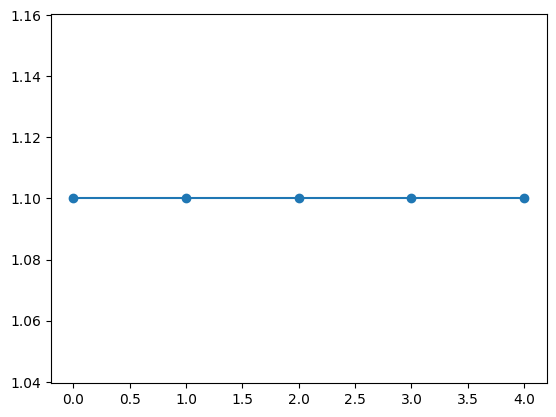

In [41]:
plt.plot(state.Uvecs[0,0,0:5],"-o")

In [22]:
#it = 0
it+=10
plt.plot(state.xg,state.Pvecs[it,0,:])
plt.ylim(np.min(state.Pvecs[0,0,:])*0.997,np.max(state.Pvecs[0,0,:])*1.01)

IndexError: index 110 is out of bounds for axis 0 with size 101

Text(0.5, 1.0, 'Density Reconstruction at Interfaces, it = 60')

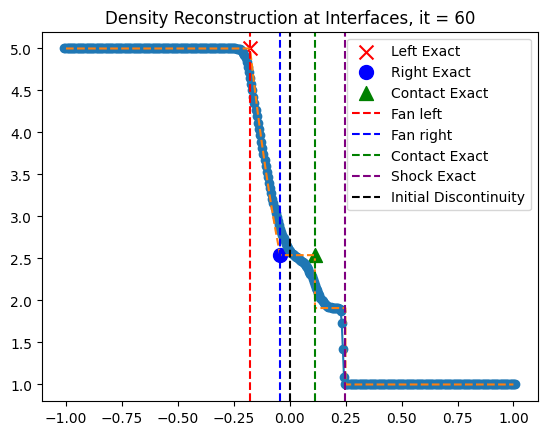

In [35]:
#it=0
it+=10
plt.plot(state.xg,state.Uvecs[it,0,:], "-o")
plt.plot(state.xghr,state.Uvecexacts[it,0,:],"--")
xintL = 0 - state.csL*state.ts[it]
xintR1 = state.vFanright*state.ts[it]
xintR2 = 0 + state.vContact*state.ts[it]
xintR3 = state.vShock*state.ts[it]
plt.scatter(xintL,state.rhoPv0[0],color='red',s=100,marker='x',label='Left Exact')
plt.scatter(xintR1,state.rho3,color='blue',s=100,marker='o',label='Right Exact')
plt.scatter(xintR2,state.rho3,color='green',s=100,marker='^',label='Contact Exact')
plt.axvline(x=xintL,color='red',linestyle='--',label = "Fan left")
plt.axvline(x=xintR1,color='blue',linestyle='--',label='Fan right')
plt.axvline(x=xintR2,color='green',linestyle='--',label='Contact Exact')
plt.axvline(x=xintR3,color='purple',linestyle='--',label='Shock Exact')
plt.axvline(x= 0,color='black',linestyle='--',label='Initial Discontinuity')
#plt.axhline(y = state.rho3)
#plt.axhline(y = state.rho4)

#plt.axhline
plt.legend()
#plt.plot(state.xgi,state.UvecintL[0,:],"-x",label='Left')
#plt.plot(state.xgi,state.UvecintR[0,:],'o',label='Right')
#plt.legend()
#plt.xlim(-0.05,0.05)
##plt.ylim(0.988,0.9924)
plt.title(f'Density Reconstruction at Interfaces, it = {it}')

Animation size has reached 21038748 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


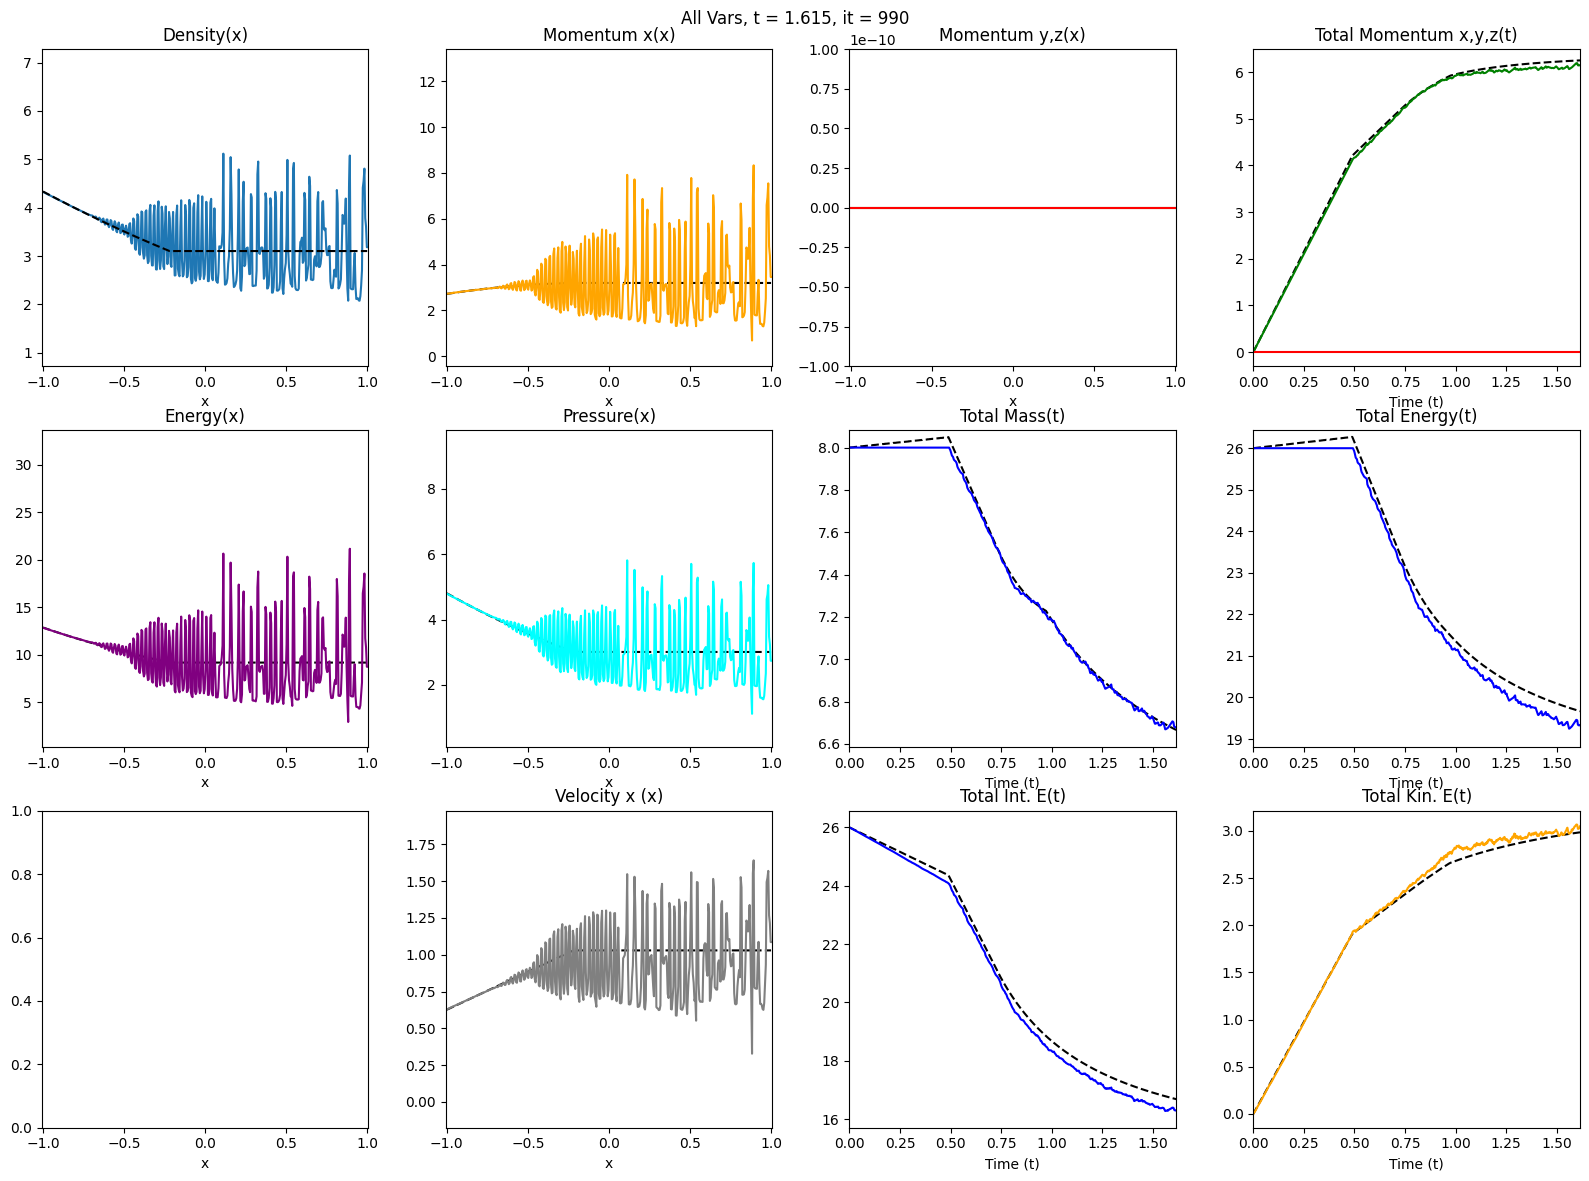

In [21]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML



frames=100
framestep = 10;
framei = np.arange(frames)*framestep
fstopt = framei[-1]+1
save = True;
if framei[-1] > state.nsteps-1:
   raise ValueError("Too many frames for number of timesteps.")

if state.boolmag:
   nplots = 16
   nrows = 4
else:
   nplots = 12
   nrows = 3
fig, axs = plt.subplots(nrows, 4, figsize=(16, nplots))
suptitle = fig.suptitle(f"All Vars, t = {state.ts[framei[0]]}, it = {framei[0]}", fontsize=12)

delfix = 1e-10 
means = state.Uvecs.mean(axis = (0,2)) #
stds = state.Uvecs.std(axis = (0,2)) #
#ymins = means - 2*stds - delfix; ymaxs = means + 2*stds + delfix;
ymins = np.min(state.Uvecs[:fstopt,:,:],axis=(0,2)) - delfix - stds/6; ymaxs = np.max(state.Uvecs[:fstopt,:,:],axis=(0,2)) + delfix + stds/6;

meansdiags = state.diagnostics.mean(axis=0)
stdsdiags = state.diagnostics.std(axis=0)
#yminsdiags = meansdiags - 2*stdsdiags - delfix; ymaxsdiags = meansdiags + 2*stdsdiags + delfix;
yminsdiags = np.min(state.diagnostics[:fstopt,:],axis=0) - delfix - stdsdiags/6; ymaxsdiags = np.max(state.diagnostics[:fstopt,:],axis=0) + delfix + stdsdiags/6;

meansprims = state.Pvecs.mean(axis=(0,2))
stdsprims = state.Pvecs.std(axis=(0,2))
#yminsaux = meansaux - 2*stdsaux - delfix; ymaxsaux = meansaux + 2*stdsaux + delfix;
yminsprims = np.min(state.Pvecs[:fstopt,:,:],axis=(0,2)) - delfix - stdsprims/6; ymaxsprims = np.max(state.Pvecs[:fstopt,:,:],axis=(0,2)) + delfix + stdsprims/6;
#Animation 4x4 plots. (rho, rhovx,rhovy/rhovz, total rhovx/rhovy/rhovz), (E,m, total energy, total mass), (P, KE, total P/gamma-1, total KE),
# (By,Bz, MagE, total MagE). Totals are animated lines moving to the right in time.
# to fix in case of zero std
if True:
   line1rho = axs[0,0].plot([],[],label='Density')[0]
   if state.ici == 0:
      line1rhoexact = axs[0,0].plot([],[],label='Exact',color='black',ls='--')[0]
      line2rhovxexact = axs[0,1].plot([],[],label='Exact',color='black',ls='--')[0]
      line5rhovxtotexact = axs[0,3].plot([],[],label='Exact',color='black',ls='--')[0]
      line8Eexact = axs[1,0].plot([],[],label='Exact',color='black',ls='--')[0]
      line9Pexact = axs[1,1].plot([],[],label='Exact',color='black',ls='--')[0]
      line10massexact = axs[1,2].plot([],[],label='Exact',color='black',ls='--')[0]
      line11Etexact = axs[1,3].plot([],[],label='Exact',color='black',ls='--')[0]
      line12KEexact = axs[2,1].plot([],[],label='Exact',color='black',ls='--')[0]
      line13utotexact = axs[2,2].plot([],[],label='Exact',color='black',ls='--')[0]
      line14KEtotexact = axs[2,3].plot([],[],label='Exact',color='black',ls='--')[0]
   line2rhovx = axs[0,1].plot([],[],label='Momentum x',color='orange')[0]
   line3rhovy = axs[0,2].plot([],[],label='Momentum y',color='green')[0]
   line4rhovz = axs[0,2].plot([],[],label='Momentum z',color='red')[0]
   line5rhovxtot = axs[0,3].plot([],[],label='Total Momentum x',color='blue')[0]
   line6rhovytot = axs[0,3].plot([],[],label='Total Momentum y',color='green')[0]
   line7rhovztot = axs[0,3].plot([],[],label='Total Momentum z',color='red')[0]


   line8E = axs[1,0].plot([],[],label='Energy',color='purple')[0]
   line9P = axs[1,1].plot([],[],label='Pressure',color='cyan')[0]
   line10mass = axs[1,2].plot([],[],label='Mass',color='blue')[0]
   line11Etot = axs[1,3].plot([],[],label='Total Energy',color='blue')[0]


   line12vx = axs[2,1].plot([],[],label='Velocity x',color='grey')[0]
   line13utot = axs[2,2].plot([],[],label='Total internal Energy',color='blue')[0]
   line14KEtot = axs[2,3].plot([],[],label='Total Kinetic Energy',color='orange')[0]


   if state.boolmag:
      line15By = axs[3,0].plot([],[],label='By',color='brown')[0]
      line16Bz = axs[3,1].plot([],[],label='Bz',color='pink')[0]
      line17ME = axs[3,2].plot([],[],label='Magnetic Energy',color='black')[0]
      line18MEtot = axs[3,3].plot([],[],label='Total Magnetic Energy',color='blue')[0]

   axs[0,0].set_ylim(ymins[0],ymaxs[0])#rho
   axs[0,1].set_ylim(ymins[1],ymaxs[1])#rhovx
   axs[0,2].set_ylim(ymins[2],ymaxs[2])#rhovy
   axs[0,3].set_ylim(yminsdiags[3],ymaxsdiags[3])#total rhovx

   axs[1,0].set_ylim(ymins[4],ymaxs[4])#E
   axs[1,1].set_ylim(yminsprims[4],ymaxsprims[4])#P
   axs[1,2].set_ylim(yminsdiags[0],ymaxsdiags[0])#total mass
   axs[1,3].set_ylim(yminsdiags[1],ymaxsdiags[1])#total energy

   axs[2,1].set_ylim(yminsprims[1],ymaxsprims[1])#velocity 
   axs[2,2].set_ylim(yminsdiags[2],ymaxsdiags[2])#total internal energy
   
   axs[2,3].set_ylim(yminsdiags[10],ymaxsdiags[10])#total kinetic energy
   if state.boolmag:
      axs[3,0].set_ylim(ymins[5],ymaxs[5])#By
      axs[3,1].set_ylim(ymins[6],ymaxs[6])#Bz
      axs[3,2].set_ylim(yminsaux[7],ymaxsaux[7])#MagE
      axs[3,3].set_ylim(yminsdiags[9],ymaxsdiags[9])#total MagE
   for idx,ax  in enumerate(axs.flat):
      if idx in [3,6,7,10,11,15]:
         ax.set_xlabel('Time (t)')
         ax.set_xlim(state.ts[framei[0]],state.ts[framei[-1]])
      else:
         ax.set_xlabel('x')
         ax.set_xlim(state.xg[0],state.xg[-1])
      # if idx in [2,3]:
      #    plt.legend()

   if state.boolmag:
      lines = [line1rho,line2rhovx,line3rhovy,line4rhovz,line5rhovxtot,line6rhovytot,line7rhovztot,
               line8E,line9P,line10mass,line11Etot,line12vx,line13utot,line14KEtot,line15By,line16Bz,line17ME,line18MEtot]
   else:
      lines = [line1rho,line2rhovx,line3rhovy,line4rhovz,line5rhovxtot,line6rhovytot,line7rhovztot,
               line8E,line9P,line10mass,line11Etot,line12vx,line13utot,line14KEtot]
   if state.ici == 0:
      lines = [*lines, line1rhoexact,line2rhovxexact,line5rhovxtotexact,
               line8Eexact,line9Pexact,line10massexact,line11Etexact,line12KEexact,line13utotexact,line14KEtotexact]

plt.tight_layout()

def init():
   titles = ['Density(x)', 'Momentum x(x)', 'Momentum y,z(x)', 'Total Momentum x,y,z(t)',
              'Energy(x)', 'Pressure(x)','Total Mass(t)', 'Total Energy(t)',
             '', 'Velocity x (x)', 'Total Int. E(t)', 'Total Kin. E(t)',
             'By(x)', 'Bz(x)', 'Magnetic Energy(x)', 'Total Magnetic Energy(t)']
   if state.boolmag:
      pass
   else:
      titles = titles[0:-4]
             
   for idx, ax in enumerate(axs.flat):
      ax.set_title(titles[idx])
   for line in lines:
      line.set_data([], [])
   return lines

def animate(frame):
   lines[0].set_data(state.xg, state.Uvecs[frame, 0, :]) #rho
   lines[1].set_data(state.xg, state.Uvecs[frame, 1, :]) #rhovx
   lines[2].set_data(state.xg, state.Uvecs[frame, 2, :]) #rhovy
   lines[3].set_data(state.xg, state.Uvecs[frame, 3, :]) #rhovz
   lines[4].set_data(state.ts[:frame+1], state.diagnostics[:frame+1, 2]) #total rhovx
   lines[5].set_data(state.ts[:frame+1], state.diagnostics[:frame+1, 3]) #total rhovy
   lines[6].set_data(state.ts[:frame+1], state.diagnostics[:frame+1, 4]) #total rhovz
   lines[7].set_data(state.xg, state.Uvecs[frame, 4, :]) #E
   lines[8].set_data(state.xg, state.Pvecs[frame, 4, :]) #P
   lines[9].set_data(state.ts[:frame+1], state.diagnostics[:frame+1, 0]) #total mass
   lines[10].set_data(state.ts[:frame+1], state.diagnostics[:frame+1, 1]) #total energy
   lines[11].set_data(state.xg, state.Pvecs[frame, 1, :]) #vx
   lines[12].set_data(state.ts[:frame+1], state.diagnostics[:frame+1, 2]) #total internal energy
   lines[13].set_data(state.ts[:frame+1], state.diagnostics[:frame+1, 10]) #total kinetic energy
   if state.ici == 0:
      lines[14].set_data(state.xghr, state.Uvecexacts[frame, 0, :]) #rho exact
      lines[15].set_data(state.xghr, state.Uvecexacts[frame, 1, :]) #rhovx exact
      lines[16].set_data(state.ts[:frame+1], state.diagnostics_exact[:frame+1, 3]) #total rhovx exact
      lines[17].set_data(state.xghr, state.Uvecexacts[frame, 4, :]) #E exact
      lines[18].set_data(state.xghr, state.Pvecexacts[frame, 4, :]) #P exact
      lines[19].set_data(state.ts[:frame+1], state.diagnostics_exact[:frame+1, 0]) #total mass exact
      lines[20].set_data(state.ts[:frame+1], state.diagnostics_exact[:frame+1, 1]) #total energy exact
      lines[21].set_data(state.xghr, state.Pvecexacts[frame, 1, :]) #vx exact
      lines[22].set_data(state.ts[:frame+1], state.diagnostics_exact[:frame+1, 2]) #total internal energy exact
      lines[23].set_data(state.ts[:frame+1], state.diagnostics_exact[:frame+1, 10]) #total kinetic energy exact
   if state.boolmag:#(mass, energy, internal energy, rhovx, rhovy, rhovz, rhov, gradP, lapP, magE, KE)
      lines[14].set_data(state.xg, state.Uvecs[frame, 5, :]) #By
      lines[15].set_data(state.xg, state.Uvecs[frame, 6, :]) #Bz
      lines[16].set_data(state.xg, state.Auxvecs[frame, 7, :]) #magE
      lines[17].set_data(state.ts[:frame+1], state.diagnostics[:frame+1, 9]) #total magE
   suptitle.set_text(f"All Vars, t = {state.ts[frame]:.3f}, it = {frame}")
   return lines

anim = FuncAnimation(fig, animate, init_func=init, frames=framei, interval=35, blit=True)
HTML(anim.to_jshtml())
if save:
   anim.save(outdir + f"anim{state.icname}.mp4", fps=15)


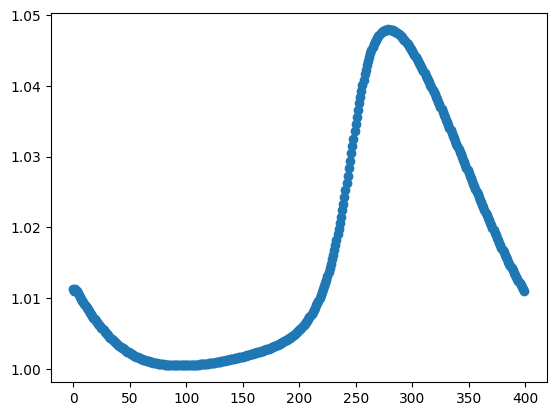

In [181]:
#it = 0
it +=10
plt.plot(state.Uvecs[it,0,:], "-o")